# Exploring the Gross-Pitaevskii equation: Simulation
##### In this notebook, we implement the Python code that solves the Gross-Pitaevskii equation, with and without the Thomas-fermi approximation.

Through the Gross-Pitaevskii equation, we want to find the wave function corresponding to the lowest energy state of the many body Hamiltonian corresponding to a system of $N$ bosons:

$$H=\sum_{i=1}^N \left[\frac{\vec{p_i}^2}{2m}+V_{ext}(\vec{r}_i)\right]+\frac{1}{2}\sum_{i\neq j}V(r_{ij})$$

Where, in our case, the external potential is described by a harmonic oscillator and the interaction energy by a contact potential. Employing the variational method, we arrive to the equation at play:

$$\left[-\frac{\hbar^2 \nabla^2}{2m} + V_{\text{ext}}(\vec{r}) + gN|\varphi(\vec{r})|^2 \right] \varphi(\vec{r}) = \mu \varphi(\vec{r})$$

By changing into harmonic oscillator units:

$$\bar{\mu} \bar{\varphi}(\vec{r}_{ho})  =  -\frac{\nabla^2}{2} \bar{\varphi}(\vec{r}_{ho}) \frac{1}{2} r_{ho}^2 \bar{\varphi}(\vec{r}_{ho}) + 4\pi \bar{a} N |\bar{\varphi}(\vec{r}_{ho})|^2 \bar{\varphi}(\vec{r}_{ho})$$

Where $\bar{a} = a_s/a_{ho}$.

We will first define our vectors as full zero arrays using the numpy library. These vectors will be progressively modified, with each component referring to the value of the magnitude in the respective spatial position.

In [67]:
import numpy as np
import matplotlib.pyplot as plt

In [62]:
# Constants
xr = np.zeros(1000) # r-space discretization
frev = np.zeros(1000) # wave function
freo = np.zeros(1000) # initial wave function
fred = np.zeros(1000) # wave function derivative
xmu = np.zeros(1000) # chemical potential
fren = np.zeros(1000) # unnormalized wave function
den_gp = np.zeros(1000) # density for the Gross-Pitaevski case
u = np.zeros(1000)

#### Numerical constants
Here, we define the parameters of the numerical method, which can be changed to study how the solutions change depending on their values.

In [63]:
# Inputs
a0=0.00433 # scattering length in h.o units
n1=700 # number of integration steps in r-grid
step=0.015 #integration step in r-space
aa=100 # number of atoms
time=0.00005 # step in time
alpha=0.3 # starting parameter of the h.o function
iterr=70000 # number of iterations

In [64]:
pi=np.pi
piin = 1.0 / (4.0 * pi)
pi2in = np.sqrt(piin)
alpha2 = alpha * alpha
cvar = 2.0 * np.sqrt(alpha) ** 3 / np.sqrt(np.sqrt(pi))

#### Building the starting wave function
It is important to note that $cequ$ can be thought of as a measure of the interactivity between the bosons, since it directly depends on $a0$, the scattering length, which represents a measure of the strength and range of the interaction between two particles.

For instance, if we want to treat the case with no potential interaction energy, we can simply set $cequ=0$, in which case the equation will reduce to:

$$\bar{\mu} \bar{\varphi} (\vec{r}_{ho}) = -\frac{\nabla^2}{2}\bar{\varphi}(\vec{r}_{ho}) + \frac{1}{2}r_{ho}^2\bar{\varphi}(\vec{r}_{ho})$$

In [65]:
xr = step * np.arange(n1) # we discretize the space
xr2 = xr * xr
frev = cvar * xr * np.exp(-0.5 * alpha2 * xr2)
freo = frev.copy()

### Gross Pitaevskii case
We will solve the equation by iteratively updating our wave function vectors.

To calculate the cinetic term, we need to numerically determine the second derivative of the wave function. We will do so using the three point formula:

$$f''(r_k)=\frac{f(r_{k+1})-2f(r_k)+f(r_{k-1})}{h^2}$$

In [66]:
itw=0
iteration=0
N_values=[100,1000,10000,100000,1000000]

for N in N_values:

    cequ = a0 * N
    as3n = N * a0 * a0 * a0
    file_name = f"convergence_{N}.txt"
    with open(file_name, "w") as file:
        file.write("")

    for it in range(0, iterr):
        itw += 1
        iteration+=1
        xnorm = 0.0
        ene0 = 0.0

        e_kin = 0.0
        e_ho = 0.0
        e_int = 0.0
        e_virial=0.0

    # We first construct our wave function derivative vector by using the three point formula, adjusting the extreme value.
        for i in range(1,n1-1):
            fred[i] = (freo[i-1] + freo[i+1] - 2.0 * freo[i]) / (step * step) 
        fred[n1-1] = (freo[n1-2] - 2.0 * freo[n1-2]) / (step * step)

        for i in range(0,n1):
            xr2=xr[i]*xr[i]
            if i==0:
                xmu[i]=0.0
            else:
                ene0=ene0-freo[i]*fred[i]*0.5+0.5*xr2*freo[i]**2+0.5*cequ*xr2*(freo[i]/xr[i])**4
                xmu[i]=-0.5*fred[i]/freo[i]+0.5*xr2+cequ*(freo[i]/xr[i])**2

                e_kin=e_kin-freo[i]*fred[i]*0.5
                e_ho=e_ho+0.5*xr2*freo[i]**2
                e_int=e_int+0.5*cequ*xr2*(freo[i]/xr[i])**4
                e_virial = 2 * e_kin - 2 * e_ho + 3 * e_int

            fren[i] = freo[i] - time * xmu[i] * freo[i]
            xnorm = xnorm+fren[i]**2
        xnorm=np.sqrt(xnorm*step)
        ene0=ene0*step
        e_virial=e_virial*step

        if itw == 200: # we print the energy every 200 iterations
            print('iteration=', iteration, '', 'ene0 =', ene0)
            itw = 0

        with open(file_name, "a") as file:
            file.write(f"{iteration}\t{ene0}\t{e_virial}\n")

    # We define the new wave function
        freo = fren / xnorm

iteration= 200  ene0 = 7.587281845969166
iteration= 400  ene0 = 6.921512100188828
iteration= 600  ene0 = 6.3675686946430305
iteration= 800  ene0 = 5.900116329750415
iteration= 1000  ene0 = 5.500851021033435
iteration= 1200  ene0 = 5.1562355352681095
iteration= 1400  ene0 = 4.8560660308524985
iteration= 1600  ene0 = 4.592517521479122
iteration= 1800  ene0 = 4.359494137185744
iteration= 2000  ene0 = 4.152178716316948
iteration= 2200  ene0 = 3.9667150622748517
iteration= 2400  ene0 = 3.799979967522933
iteration= 2600  ene0 = 3.649416993803683
iteration= 2800  ene0 = 3.5129134400916713
iteration= 3000  ene0 = 3.3887079949523393
iteration= 3200  ene0 = 3.2753205200374573
iteration= 3400  ene0 = 3.1714980223589246
iteration= 3600  ene0 = 3.0761726251264587
iteration= 3800  ene0 = 2.988428540592235
iteration= 4000  ene0 = 2.9074758734851316
iteration= 4200  ene0 = 2.8326296620046425
iteration= 4400  ene0 = 2.763292974144162
iteration= 4600  ene0 = 2.698943172518686
iteration= 4800  ene0 = 2.6

In [28]:
# Calculation of the radius, potential, kinetic energy, density, and single particle potential

for i in range(1,n1-1):
    fred[i] = (freo[i-1] + freo[i+1] - 2.0 * freo[i]) / (step * step)
fred[n1-1] = (freo[n1-2] - 2.0 * freo[n1-2]) / (step * step)

radious = 0.0
xkin = 0.0
poth0 = 0.0
potself = 0.0
chem=0.0
xaver=0.0
xnormden=0.0

for i in range(1,n1):
    xr2=xr[i]*xr[i]
    radious=radious+xr2*freo[i]*freo[i]
    xkin=xkin+freo[i]*fred[i]
    poth0=poth0+xr2*freo[i]*freo[i]
    potself=potself+xr2*(freo[i]/xr[i])**4
    chem=chem+xmu[i]*freo[i]*freo[i]
    u[i]=0.5*xr2+cequ*(freo[i]/xr[i])**2
    den_gp[i]=(freo[i]/xr[i])**2
    xnormden=xnormden+den_gp[i]*xr2
    xaver=xaver+freo[i]*freo[i]*as3n*den_gp[i]

radious2=radious*step
radious=np.sqrt(radious*step)
xaver=xaver*step
chem=chem*step
xkin=-xkin*step*0.5
poth0=0.5*poth0*step
potself=potself*step*cequ*0.5
pot=potself+poth0
xnormden=xnormden*step

print('xnormden=',xnormden)
print('ene0=',ene0)
print('chem=',chem)
print('xkin=',xkin)
print('pot=',pot)
print('poth0=',poth0)
print('potself=',potself)
print('radious=',radious)
print('radious2=',radious2)

xnormden= 0.9999999999999996
ene0= 12.103949905268252
chem= 16.846593570966775
xkin= 0.12367139605981062
pot= 11.980278509208391
poth0= 7.237634843491473
potself= 4.742643665716918
radious= 3.8046379179868017
radious2= 14.475269686982946


### Thomas-Fermi case
The following code is exactly the same as before, with the difference being that no kinetic energy is being considered. Theoretically, this contribution can be neglected in front of the harmonic trap and interacting energy when we consider strong repulsive interactions.

In this approximation, we have:

$$\bar{\mu} \bar{\varphi}(\vec{r}_{ho}) = \frac{1}{2} r_{ho}^2 \bar{\varphi}(\vec{r}_{ho}) + 4\pi \bar{a} N |\varphi(\vec{r}_{ho})|^2 \varphi (\vec{r}_{ho})$$

In [29]:
# Constants
xr = np.zeros(1000)
frev = np.zeros(1000)
freo = np.zeros(1000)
fred = np.zeros(1000)
xmu = np.zeros(1000)
fren = np.zeros(1000)
den_tf = np.zeros(1000)
u = np.zeros(1000)

In [30]:
# We first build the starting wave function R(r)
xr = step * np.arange(n1)
xr2 = xr * xr
frev = cvar * xr * np.exp(-0.5 * alpha2 * xr2)
freo = frev.copy()

As we said, we will need the time derivatives of the wave function to be null in order to neglect the kinetic term.

In [31]:
itw=0
for it in range(0, iterr):
    itw += 1
    xnorm = 0.0
    ene0 = 0.0

# Here, we set the wave function derivative vector to zero
    for i in range(1,n1-1):
        fred[i] = 0.0
    fred[n1-1] = 0.0

    for i in range(0,n1):
        xr2=xr[i]*xr[i]
        if i==0:
            xmu[i]=0.0
        else:
            ene0=ene0-freo[i]*fred[i]*0.5+0.5*xr2*freo[i]**2+0.5*cequ*xr2*(freo[i]/xr[i])**4
            xmu[i]=-0.5*fred[i]/freo[i]+0.5*xr2+cequ*(freo[i]/xr[i])**2
        fren[i] = freo[i] - time * xmu[i] * freo[i]
        xnorm = xnorm+fren[i]**2
    xnorm=np.sqrt(xnorm*step)
    ene0=ene0*step

    if itw == 200:
        print('ene0 =', ene0)
        itw = 0

# We define the new wave function
    freo = fren / xnorm

    if it == iter:
        for i in range(1, n1):
            print(xr[i], xmu[i])

ene0 = 12.74440309603823
ene0 = 12.577664068348088
ene0 = 12.458739925112337
ene0 = 12.370773439241319
ene0 = 12.303869491387253
ene0 = 12.251823052559317
ene0 = 12.210560557569295
ene0 = 12.177313128447294
ene0 = 12.150144993584584
ene0 = 12.127670225303717
ene0 = 12.108875806275924
ene0 = 12.093007603401611
ene0 = 12.079494937286341
ene0 = 12.067899541788679
ene0 = 12.05788032679537
ene0 = 12.049168606239046
ene0 = 12.041550392730924
ene0 = 12.03485354906206
ene0 = 12.028938332527398
ene0 = 12.023690345277029
ene0 = 12.019015214952693
ene0 = 12.014834535986402
ene0 = 12.011082740651196
ene0 = 12.007704663654849
ene0 = 12.00465362959883
ene0 = 12.001889938559215
ene0 = 11.999379657629307
ene0 = 11.997093649645553
ene0 = 11.995006787276665
ene0 = 11.993097313082194
ene0 = 11.991346315341897
ene0 = 11.989737296320019
ene0 = 11.988255814800176
ene0 = 11.98688918864847
ene0 = 11.98562624616946
ene0 = 11.984457117328736
ene0 = 11.983373057714733
ene0 = 11.982366299514917
ene0 = 11.98142992

In [32]:
# Calculation of the radius, potential, kinetic energy, density, and single particle potential

for i in range(1,n1-1):
    fred[i] = (freo[i-1] + freo[i+1] - 2.0 * freo[i]) / (step * step)
fred[n1-1] = (freo[n1-2] - 2.0 * freo[n1-2]) / (step * step)

radious = 0.0
xkin = 0.0
poth0 = 0.0
potself = 0.0
chem=0.0
xaver=0.0
xnormden=0.0

for i in range(1,n1):
    xr2=xr[i]*xr[i]
    radious=radious+xr2*freo[i]*freo[i]
    xkin=xkin+freo[i]*fred[i]
    poth0=poth0+xr2*freo[i]*freo[i]
    potself=potself+xr2*(freo[i]/xr[i])**4
    chem=chem+xmu[i]*freo[i]*freo[i]
    u[i]=0.5*xr2+cequ*(freo[i]/xr[i])**2
    den_tf[i]=(freo[i]/xr[i])**2
    xnormden=xnormden+den_tf[i]*xr2
    xaver=xaver+freo[i]*freo[i]*as3n*den_tf[i]

radious2=radious*step
radious=np.sqrt(radious*step)
xaver=xaver*step
chem=chem*step
xkin=-xkin*step*0.5
poth0=0.5*poth0*step
potself=potself*step*cequ*0.5
pot=potself+poth0
xnormden=xnormden*step

print('xnormden=',xnormden)
print('ene0=',ene0)
print('chem=',chem)
print('xkin=',xkin)
print('pot=',pot)
print('poth0=',poth0)
print('potself=',potself)
print('radious=',radious)
print('radious2=',radious2)

xnormden= 1.0000000000000004
ene0= 11.964009790016101
chem= 16.745408636659928
xkin= 0.21700411232374434
pot= 11.964009786670257
poth0= 7.182610832920015
potself= 4.781398953750241
radious= 3.790147974135051
radious2= 14.36522166584003


#### Density profile
Here, we write down in a file both density profiles peviously calculated: den_gp and den_tf.

In [33]:
with open("density_data_N100000.txt", "w") as file:
    for i in range(1, n1):
        file.write(f"{xr[i]} {den_gp[i]} {den_tf[i]}\n")

Now, we can plot both density profiles and see how they behave for a certain number of bosons $N$. You can modify the code so that it suits the $N$ you are working with.

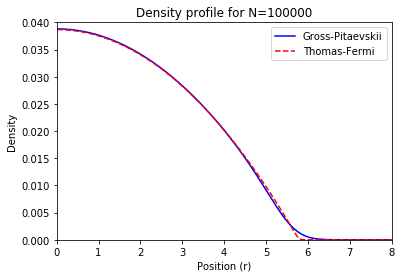

In [36]:
data = np.loadtxt("density_data_N100000.txt")
xr = data[:, 0]
den_gp = data[:, 1]
den_tf = data[:, 2]

plt.xlim(0,8)
plt.ylim(0,0.04)
plt.plot(xr, den_gp, 'b-', label='Gross-Pitaevskii')
plt.plot(xr, den_tf, 'r--', label='Thomas-Fermi')
plt.xlabel('Position (r)')
plt.ylabel('Density')
plt.legend()
plt.title('Density profile for N=100000')
plt.show()

### Convergence
We can now see how the value for the ground state energy converges to the value found at the table in our paper. Additionally, we have studied how the Virial Theorem holds for this system, finding that the expression:

$$2\bar{\epsilon}_{kin}-2\bar{\epsilon}_{ho} + 3\bar{\epsilon}_{int}$$

Rapidly converges to zero with very few iterations, as we would expect

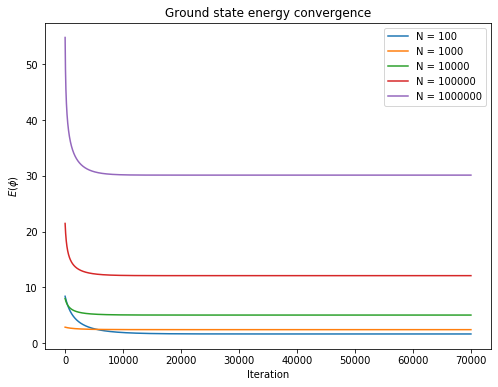

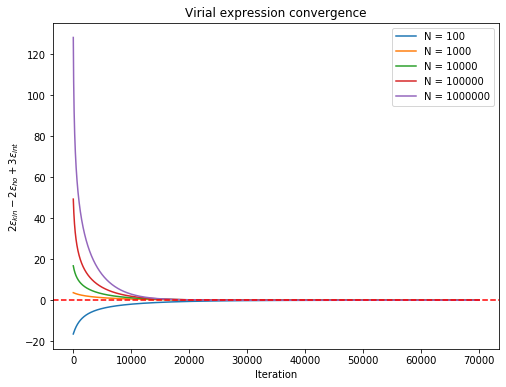

In [77]:
# List of N values
N_values = [100,1000, 10000, 100000, 1000000]
k=0
# Plot for ene0 convergence
plt.figure(figsize=(8, 6))
for N in N_values:
    iteration = []
    ene0_values = []
    
    # Read convergence data from file
    with open(f"convergence_{N}.txt", 'r') as file:
        for line in file:
            data = line.strip().split()
            iteration.append(int(data[0])-70000*k)
            ene0_values.append(float(data[1]))

    plt.plot(iteration, ene0_values, label=f"N = {N}")
    k=k+1
plt.xlabel('Iteration')
plt.ylabel('$E(\phi)$')
plt.title('Ground state energy convergence')
plt.legend()
plt.grid(False)
plt.show()

# Plot for e_virial convergence
k=0
plt.figure(figsize=(8, 6))
for N in N_values:
    iteration = []
    e_virial_values = []

    # Read convergence data from file
    with open(f"convergence_{N}.txt", 'r') as file:
        for line in file:
            data = line.strip().split()
            iteration.append(int(data[0])-70000*k)
            e_virial_values.append(float(data[2]))

    plt.plot(iteration, e_virial_values, label=f"N = {N}")
    k=k+1
plt.axhline(0, linestyle='--', color='red')  # Horizontal dotted red line at e_virial=0
plt.xlabel('Iteration')
plt.ylabel('$2\epsilon_{kin}-2\epsilon_{ho}+3\epsilon_{int}$')
plt.title('Virial expression convergence')
plt.legend()
plt.grid(False)
plt.show()